# **1. Introduction**

### **Objective**
The objective of this project is to find the best neighbourhood in Toronto to open a Indian Restaurant using Foursquare location data. In this project I will try to find solution for avoiding or considering low risk criteria and high success rate.
### **Target Audiance**
* Business professional who wants to invest or open a restaurant.
* students or bachelors  who want to stay in a Toronto and want to find facilities like Library, saloon, GYM, Club, Playground,Movie theatre etc.
* The freelancer who loves to have their own small company or restaurant as a side business.
* Marketing companies who want to release a new product on a best place.
* People or Tourist who wants to eat Indian food.

### **Data Description**

1. **Toronto City data that contains Borough, Neighborhoods along with there latitudes and longitudes**
**Data Source:** https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 This Wikipedia page contain all the information we need to explore and cluster the neighborhoods in Toronto. We will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the Toronto dataset.
2. **Geographical Location data using Geocoder Package**
**Data Source:** https://cocl.us/Geospatial_data
The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes.
3. **Venue Data using Foursquare API**
**Data Source:** https://foursquare.com/developers/apps
 From Foursquare API we can get the name,category,latitude,longitude for each venue.


# **2. Import Libraries**

In [45]:
import random # library for random number generation
# import all necessary libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# library to handle JSON files
import json 

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML, display
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#! pip install folium==0.5.0
import folium # plotting library
import warnings
warnings.filterwarnings('ignore')
print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


# **3. Scrape Neighborhoods Data**

In [2]:
# Get the neighborhood data using beautiful soup 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [3]:
# Scrape the neighborhood data from the table in the wikipedia page of Toronto
table_contents=[]
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [4]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

# **4. Data Pre-processing**

- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11  in the above table.
- If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.




In [5]:
# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [6]:
# check for missing value
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [7]:
# Check if any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [8]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [9]:
# shape of dataframe
df.shape

(103, 3)

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [10]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Now we'll merge the **geographical dataframe** with **neighborhood dataframe** according to the **Postal Code**

In [11]:
# Merge the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [12]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

### 4.1. Now we will visualize all the borough present in Toronto

In [13]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [14]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [15]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [16]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [56]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label ,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  


display(map_toronto)

In [57]:
map_toronto.save('index.html')

### 4.2. Next we will define foursquare Credentials

In [19]:
CLIENT_ID = 'QKHGFSVVYWZ43USP1H0AR5VOHAKUBVILGHSNV04WHWWFFM5D' # your Foursquare ID
CLIENT_SECRET = 'OUQGEKHUBHXYE2U2R2HM2KJAFRJCYXDYRVZTN03FIMSE41LI' # your Foursquare Secret
VERSION = 20210728 # Foursquare API version

print('Credentials Stored')

Credentials Stored


### 4.3. Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

First, let's create the GET request URL

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [33]:
toronto_venues.tail()

Neighborhood  \
2137  Mimico NW, The Queensway West, South of Bloor,...   
2138  Mimico NW, The Queensway West, South of Bloor,...   
2139  Mimico NW, The Queensway West, South of Bloor,...   
2140  Mimico NW, The Queensway West, South of Bloor,...   
2141  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
2137              43.628841              -79.520999   
2138              43.628841              -79.520999   
2139              43.628841              -79.520999   
2140              43.628841              -79.520999   
2141              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
2137                Jim & Maria's No Frills       43.631152       -79.518617   
2138  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
2139                      Once Upon A Child       43.631075       -79.518290   
2140                   Kingsway Boxing Club       43.627254       -79.526684   
2141                           Burrito Boyz       43.626657       -79.526349   

     Venue Category  
2137  Grocery Store  
2138  Tanning Salon  
2139     Kids Store  
2140            Gym  
2141  Burrito Place

Lets check how many venues are there per neighborhood

In [34]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  6   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      28   
Berczy Park                                                            58   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           22   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               8   
Central Bay Street                                                     68   
Christie                                                               15   
Church and Wellesley                                                   75   
Clairville, Humberwood, Woodbine Downs, West Hu...                      5   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             37   
Davisville North                                                        7   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         5   
Don Mills South                                                        19   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview Central                                                       4   
Downsview East                                                          3   
Downsview Northwest                                                     4   
Downsview West                                                          5   
Dufferin, Dovercourt Village                                           14   
Enclave of L4W                                                         13   
Enclave of M4L                                                         17   
Enclave of M5E                                                         97   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           65   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          25   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         23   
Kennedy Park, Ionview, East Birchmount Park                             5   
Kensington Market, Chinatown, Grange Park                              64   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

### 4.4. How many unique venues are there in all neighborhood ?

In [35]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques vanue categories.


In [36]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'French Restaurant' 'Intersection'
 'Pizza Place' 'Bakery' 'Distribution Center' 'Restaurant' 'Spa'
 'Gym / Fitness Center' 'Pub' 'Breakfast Spot' 'Historic Site'
 'Chocolate Shop' 'Farmers Market' 'Performing Arts Venue' 'Dessert Shop'
 'Mexican Restaurant' 'Theater' 'Yoga Studio' 'Shoe Store' 'Café'
 'Event Space' 'Asian Restaurant' 'Electronics Store' 'Art Gallery' 'Bank'
 'Beer Store' 'Health Food Store' 'Wine Shop' 'Antique Shop' 'Boutique'
 'Furniture / Home Store' 'Vietnamese Restaurant' 'Clothing Store'
 'Accessories Store' 'Athletics & Sports' 'Italian Restaurant' 'Beer Bar'
 'Creperie' 'Sushi Restaurant' 'Burrito Place' 'Fried Chicken Joint'
 'Hobby Shop' 'Diner' 'Japanese Restaurant' 'Smoothie Shop'
 'Sandwich Place' 'Gym' 'College Auditorium' 'Bar' 'Music Venue'
 'Caribbean Restaurant' 'Gastropub' 'Pharmacy' 'Flea Market' 'Comic Shop'
 'Plaza' 'B

## 4.5. Are there any Indian Restaurants present in the venues?

In [37]:
"Indian Restaurant" in toronto_venues['Venue Category'].unique()

True

# **5. Data Analysis**

### 5.1. Now we will analyze each neighborhood

As the column "Venue Category" contain categorical value.So we need to convert it to numerical values by one hot encoding.

In [38]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2142, 270)


Neighborhoods  Accessories Store  Airport  Airport Food Court  \
0         Parkwoods                  0        0                   0   
1         Parkwoods                  0        0                   0   
2         Parkwoods                  0        0                   0   
3  Victoria Village                  0        0                   0   
4  Victoria Village                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0          0       0           0              0          0         0   
1          0       0           0              0          0         0   
2          0       0           0              0          0         0   
3          0       0           0              0          0         0   
4          0       0           0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0             

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [39]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(100, 270)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0               0.0             0.000000           0.0       0.0          0.0   
1               0.0             0.000000           0.0       0.0          0.0   
2               0.0             0.000000           0.0       0.0          0.0   
3               0.0             0.000000           0.0       0.0          0.0   
4               0.0             0.035714           0.0       0.0          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.0                  0.0               0.0                 0.0   
1         0.0                  0.0               0.0                 0.0   
2         0.0                  0.0               0.0                 0.0   
3         0.0                  0.0               0.0                 0.0   
4         0.0                  0.0               0.0                 0.0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0          0.0            0.0        0.0         0.0         0.0     0.0   
1          0.0            0.0        0.0         0.0         0.0     0.0   
2          0.0            0.0        0.0         0.0         0.0     0.0   
3          0.0            0.0        0.0         0.0         0.0     0.0   
4          0.0            0.0        0.0         0.0         0.0     0.0   

       Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.000000  0.0             0.0               0.0               0.0   
1  0.000000  0.0             0.0               0.0               0.0   
2  0.095238  0.0             0.0               0.0               0.0   
3  0.250000  0.0             0.0               0.0               0.0   
4  0.000000  0.0             0.0               0.0               0.0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0.0    0.0              0.0       0.0         0.0   
1                 0.0    0.0              0.0       0.0         0.0   
2                 0.0    0.0              0.0       0.0         0.0   
3                 0.0    0.0              0.0       0.0         0.0   
4                 0.0    0.0              0.0       0.0         0.0   

   Belgian Restaurant  Bike Shop  Bistro  Board Shop  Boat or Ferry  \
0                 0.0        0.0     0.0         0.0            0.0   
1                 0.0        0.0     0.0         0.0            0.0   
2                 0.0        0.0     0.0         0.0            0.0   
3                 0.0        0.0     0.0         0.0            0.0   
4                 0.0        0.0     0.0         0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0            0.25      0.0   
1        0.0       0.0                   0.0            0.00      0.0   
2        0.0       0.0                   0.0            0.00      0.0   
3        0.0       0.0                   0.0            0.00      0.0   
4        0.0       0.0                   0.0            0.

Here we only require the "Neighborhoods" and "Indian Restaurant" columns for the clustering. So we'll group these two columns.

In [40]:
indian_reastaurent = to_grouped[["Neighborhoods","Indian Restaurant"]]
indian_reastaurent.head()

Neighborhoods  Indian Restaurant
0                                        Agincourt           0.000000
1                           Alderwood, Long Branch           0.000000
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000
3                                  Bayview Village           0.000000
4                Bedford Park, Lawrence Manor East           0.035714

In [41]:
# rename column "Neighborhoods" to "Neighborhood"
indian_reastaurent = indian_reastaurent.rename(columns={'Neighborhoods':'Neighborhood'})


# **6. Clustering**
We will use k-means clustering. But first we will find the best _K_ value using the **Elbow Point** method.

### 6.1. Elbow Method

In [42]:
# drop "Neighborhood" column from the dataframe
X = indian_reastaurent.drop(['Neighborhood'], axis=1)

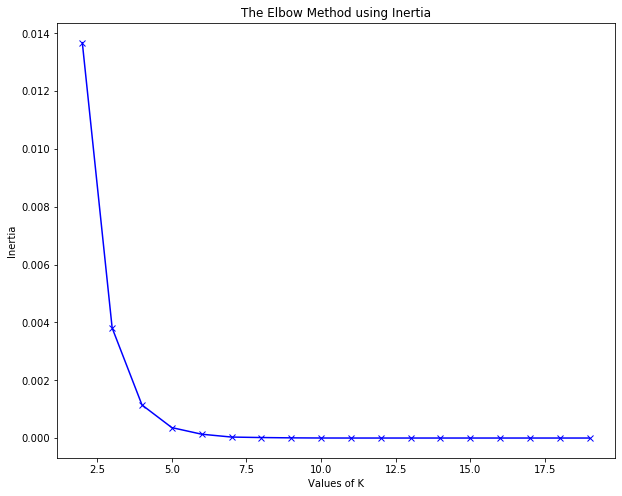

In [46]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show();

Here,We saw that the optimum K value is 4 so we will have a resulting of 4 clusters.

In [47]:
kclusters = 4

toronto_grouped_clustering = indian_reastaurent.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [48]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

 Now create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = indian_reastaurent.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [50]:
to_merged.head()

Neighborhood  Indian Restaurant  \
0                                        Agincourt           0.000000   
1                           Alderwood, Long Branch           0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000   
3                                  Bayview Village           0.000000   
4                Bedford Park, Lawrence Manor East           0.035714   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [51]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2142, 9)


Neighborhood  Indian Restaurant  Cluster Labels  \
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
1  Alderwood, Long Branch                0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                            Mark's       43.791179       -79.259714   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0             Clothing Store  
1                Pizza Place

In [52]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2142, 9)


Neighborhood  Indian Restaurant  Cluster Labels  \
86  Thorncliffe Park           0.090909               3   
86  Thorncliffe Park           0.090909               3   
86  Thorncliffe Park           0.090909               3   
86  Thorncliffe Park           0.090909               3   
86  Thorncliffe Park           0.090909               3   

    Neighborhood Latitude  Neighborhood Longitude                       Venue  \
86              43.705369              -79.349372                    Fit4Less   
86              43.705369              -79.349372  Iqbal Kebab & Sweet Centre   
86              43.705369              -79.349372                      Costco   
86              43.705369              -79.349372                 Tim Hortons   
86              43.705369              -79.349372              Kandahar Kabab   

    Venue Latitude  Venue Longitude             Venue Category  
86       43.705689       -79.346018                        Gym  
86       43.705923       -79.351521          Indian Restaurant  
86       43.707051       -79.348093            Warehouse Store  
86       43.705090       -79.350545                Coffee Shop  
86       43.705250       -79.348625  Middle Eastern Restaurant

Lets check how many Indian Restaurant are there

In [53]:
to_merged['Venue Category'].value_counts()['Indian Restaurant']

12

We see that there are a total of **47** locations with Indian Restaurants in Toronto  
We will create a new dataframe with the Neighborhood and Indian Restaurants

## 6.2. Visualize Clustering on Google Map

In [58]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [59]:
map_clusters.save("index2.html")

## 6.2. How many Neighborhoods per Cluster?


In [60]:
indian_reastaurent["Cluster Labels"] = kmeans.labels_
indian_reastaurent.head()

Neighborhood  Indian Restaurant  \
0                                        Agincourt           0.000000   
1                           Alderwood, Long Branch           0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000   
3                                  Bayview Village           0.000000   
4                Bedford Park, Lawrence Manor East           0.035714   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

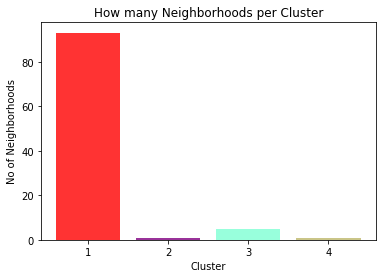

In [61]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = indian_reastaurent['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [62]:
# How many neighborhoods in each cluster
indian_reastaurent['Cluster Labels'].value_counts()

0    93
2     5
1     1
3     1
Name: Cluster Labels, dtype: int64

## 6.3. Analysis of each Cluster

### Cluster 1

In [63]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [64]:
# Red 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Indian Restaurant  Cluster Labels  \
0  North York         Parkwoods                0.0               0   
1  North York         Parkwoods                0.0               0   
2  North York         Parkwoods                0.0               0   
3  North York  Victoria Village                0.0               0   
4  North York  Victoria Village                0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.753259              -79.329656   
1              43.753259              -79.329656   
2              43.753259              -79.329656   
3              43.725882              -79.315572   
4              43.725882              -79.315572   

                                       Venue  Venue Latitude  Venue Longitude  \
0                              Variety Store       43.751974       -79.333114   
1                                        KFC       43.754387       -79.333021   
2                            Brookbanks Park       43.751976       -79.332140   
3                                 Pizza Nova       43.725824       -79.312860   
4  Eglinton Ave E & Sloane Ave/Bermondsey Rd       43.726086       -79.313620   

         Venue Category  
0     Food & Drink Shop  
1  Fast Food Restaurant  
2                  Park  
3           Pizza Place  
4          Intersection

### Cluster 2

In [65]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough                                       Neighborhood  \
0  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
1  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
2  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
3  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
4  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   

   Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
0           0.333333               1               43.75741   
1           0.333333               1               43.75741   
2           0.333333               1               43.75741   
3           0.333333               1               43.75741   
4           0.333333               1               43.75741   

   Neighborhood Longitude                                        Venue  \
0              -79.273304                                  Pho Vietnam   
1              -79.273304                     Big Al's Pet Supercentre   
2              -79.273304  Karaikudi Chettinad South Indian Restaurant   
3              -79.273304                              Scarborough LRT   
4              -79.273304                                      Kairali   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.757770       -79.278572  Vietnamese Restaurant  
1       43.759279       -79.278325              Pet Store  
2       43.756042       -79.276276      Indian Restaurant  
3       43.756465       -79.272194     Light Rail Station  
4       43.754915       -79.276945      Indian Restaurant

### Cluster 3

In [66]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough                  Neighborhood  Indian Restaurant  \
0  East Toronto  The Danforth West, Riverdale            0.02381   
1  East Toronto  The Danforth West, Riverdale            0.02381   
2  East Toronto  The Danforth West, Riverdale            0.02381   
3  East Toronto  The Danforth West, Riverdale            0.02381   
4  East Toronto  The Danforth West, Riverdale            0.02381   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               2              43.679557              -79.352188   
1               2              43.679557              -79.352188   
2               2              43.679557              -79.352188   
3               2              43.679557              -79.352188   
4               2              43.679557              -79.352188   

               Venue  Venue Latitude  Venue Longitude      Venue Category  
0  Pizzeria Libretto       43.678489       -79.347576         Pizza Place  
1     Dough Bakeshop       43.676643       -79.356846              Bakery  
2          Menchie's       43.678309       -79.348105  Frozen Yogurt Shop  
3            Bar Oak       43.677931       -79.348724              Lounge  
4               LCBO       43.676816       -79.356047        Liquor Store

### Cluster 4

In [67]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough      Neighborhood  Indian Restaurant  Cluster Labels  \
0  East York  Thorncliffe Park           0.090909               3   
1  East York  Thorncliffe Park           0.090909               3   
2  East York  Thorncliffe Park           0.090909               3   
3  East York  Thorncliffe Park           0.090909               3   
4  East York  Thorncliffe Park           0.090909               3   

   Neighborhood Latitude  Neighborhood Longitude              Venue  \
0              43.705369              -79.349372       Leaside park   
1              43.705369              -79.349372       Swiss Chalet   
2              43.705369              -79.349372          Dollarama   
3              43.705369              -79.349372  Cross Fit Quantum   
4              43.705369              -79.349372            Quiznos   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.702177       -79.351377                  Park  
1       43.707786       -79.344132            Restaurant  
2       43.705689       -79.346018        Discount Store  
3       43.706883       -79.350819  Gym / Fitness Center  
4       43.705887       -79.347023        Sandwich Place

## 6.4. Number of neighborhoods per cluster *vs* Average number of Indian Restaurants in each Cluster

Text(0.5, 1.0, 'Average number of Indian Restaurants per Cluster')

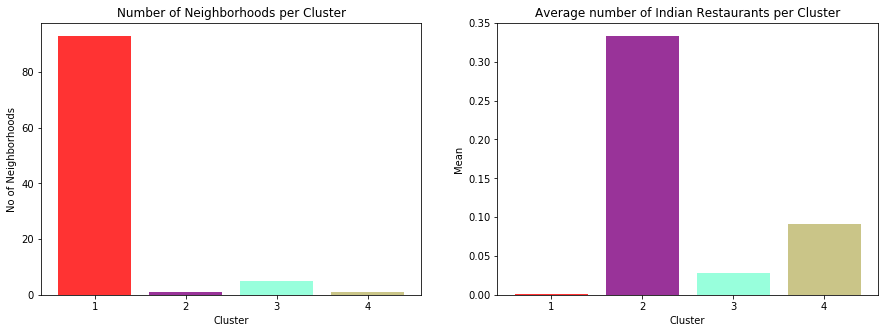

In [68]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = indian_reastaurent['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Indian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Indian Restaurant'].mean(),df_cluster2['Indian Restaurant'].mean(),df_cluster3['Indian Restaurant'].mean(),
                df_cluster4['Indian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Indian Restaurants per Cluster')


# **7. Conclusion**

The Neighborhoods located in the East Toronto area(cluster-2) have the highest average of Indian Restaurants which is represented by violet colour. Riverdale has second heighest number of Indian Restaurants present. Looking at the nearby venues, the optimum place to put a new Indian Restaurant is in Victoria village,North York(cluster-4) as their are many Neighborhoods in that area but a little number of Indian Restaurants therefore, eliminating any competition.The second best Neighborhoods that have a great oppurtunity would be in areas such as Queen's Park which is in Cluster 1. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Indian Restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.

**Here we take an Indian Restaurant as an example. We can do the same process to find the best place or neighborhood**
- to open a start up company 
- to stay on rent for bachelors
- to start a side business for middle class people
- to open a camp for any kind of servey
- to release a new product for checking the success rate
  